<div style="float: block; text-align: center; line-height: 1.7em">
    <span style="font-size: 2em; font-weight: bold"> Fatigue-Sleepiness in Irregular Workloads for Pilots </span><br>
    <span style="font-size: 1.5em; font-weight: bold"> Statistical Modelling - Perceived Sleepiness </span><br>
</div>

---

# 1. Loading required libraries

In [4]:
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM

import statsmodels.api as sm
import statsmodels.formula.api as smf

---

# 2. Loading Data

In [5]:
file = os.path.join('data','processed_to_regression.csv')
df = pd.read_csv(file)

df.head(5)

,Id,Record_time_stamp,kss,sps,quest_fill_hour,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,...,Flight_hours,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,Classification,select
0,P01,07/12/2021 12:21,5,4.0,AFT,start,others,0,0,8.883333,...,17000.0,univ,married,60,49,13,9,14,INT,1
1,P01,07/12/2021 19:57,5,5.0,EVE,middle,others,0,0,8.900000,...,17000.0,univ,married,60,49,13,9,14,INT,1
2,P01,08/12/2021 00:15,7,6.0,NI,end,others,0,0,8.916667,...,17000.0,univ,married,60,49,13,9,14,INT,1
3,P01,09/12/2021 05:20,7,5.0,NI,start,early-start,0,0,5.450000,...,17000.0,univ,married,60,49,13,9,14,INT,1
4,P01,09/12/2021 09:50,4,3.0,MOR,middle,early-start,0,0,5.466667,...,17000.0,univ,married,60,49,13,9,14,INT,1


In [6]:
working_df = df[df['workload_moment'].isin(['start','middle','end'])]
working_df.head(5)

,Id,Record_time_stamp,kss,sps,quest_fill_hour,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,...,Flight_hours,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,Classification,select
0,P01,07/12/2021 12:21,5,4.0,AFT,start,others,0,0,8.883333,...,17000.0,univ,married,60,49,13,9,14,INT,1
1,P01,07/12/2021 19:57,5,5.0,EVE,middle,others,0,0,8.900000,...,17000.0,univ,married,60,49,13,9,14,INT,1
2,P01,08/12/2021 00:15,7,6.0,NI,end,others,0,0,8.916667,...,17000.0,univ,married,60,49,13,9,14,INT,1
3,P01,09/12/2021 05:20,7,5.0,NI,start,early-start,0,0,5.450000,...,17000.0,univ,married,60,49,13,9,14,INT,1
4,P01,09/12/2021 09:50,4,3.0,MOR,middle,early-start,0,0,5.466667,...,17000.0,univ,married,60,49,13,9,14,INT,1


---

# 3. Preparing Data to Regression Analysis

The sps and kss scales were taken along each workloads in three moments, the start, middle and end in an irregular way, i.e., some participants have filled the scales more frequently than others generating an inbalance in measurements for each participant. As the pilots workloads are irregular, the start, middle and end of workload can occur at different hours along the day, categorized into the following categories, EM, MOR, AFT, EVE, NI.

To tackle this kind of problem a mixed model with cluster in participant is ideal, i.e. a model whith a random intercept for each participant. However, the measurements were taken irregularly along various hours of the day, so we will assume another random intercept and a random slope in hour of the day wherein the kss and sps scales were filled.

## 3.1. Counting and removing nan rows

### 3.1.1. Function to diplay side by side

In [7]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").format(precision=2)\
                          .set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

### 3.1.2. Getting NaN values number per column

In [8]:
wsm = working_df.isna().sum()
display_side_by_side([pd.DataFrame(wsm[0:6]), pd.DataFrame(wsm[6:12]), pd.DataFrame(wsm[12:18]),pd.DataFrame(wsm[18:])],
                    ['(a)','(b)','(c)','(d)'])

,0
Id,0
Record_time_stamp,0
kss,0
sps,1
quest_fill_hour,0
workload_moment,0
,0
workload_type,0
workload_type_prev_es,0
workload_type_prev_nt,0


As we can see few values of NaN is present in our data set, once we have more than 1k rows, we can remove these rows without great impacts in forward analysis

### 3.1.3. Removing NaN rows

In [9]:
working_df = working_df.dropna()

wsm = working_df.isna().sum()
print(''); print('')
display_side_by_side([pd.DataFrame(wsm[0:6]), pd.DataFrame(wsm[6:12]), pd.DataFrame(wsm[12:18]),pd.DataFrame(wsm[18:])],
                    ['(a)','(b)','(c)','(d)'])
print(''); print('')

,0
Id,0
Record_time_stamp,0
kss,0
sps,0
quest_fill_hour,0
workload_moment,0
,0
workload_type,0
workload_type_prev_es,0
workload_type_prev_nt,0


### 3.1.4. Re-scaling some variables

In [10]:
working_df['flight_hours'] = working_df['Flight_hours'].copy()/1000
working_df['age'] = working_df['Age'].copy()/10
working_df['time_displacement'] = working_df['Time_displacement'].copy()/60

**Now the data is ready for analysis!**

# 4. Regression Analysis

## 4.1. Function to codify formula in statsmodel standard

In [11]:
def get_formula(covariates, target, prnt = False):
    formula = f'{target}~'
    for cvt in covariates:
        formula += cvt+'+'
    formula = formula[:-1]
    if prnt:
        print(f'formula:\n{formula}')
    return formula

## 4.2. First Iteration

In [12]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

covariates = ['workload_moment','workload_type','quest_fill_hour','workload_type_prev_es','workload_type_prev_nt',
              'workload_length','sleep_duration','time_awake','Position','Num_Sons','flight_hours','education',
              'marital_status','time_displacement','age','Num_Sons','Classification']

formula = get_formula(covariates, 'kss')

md = smf.mixedlm(formula, working_df, groups=working_df["Id"], re_formula = 'quest_fill_hour')
mdf = md.fit()
print(mdf.summary())

                             Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              kss       
No. Observations:              1014                 Method:                          REML      
No. Groups:                    43                   Scale:                           2.1305    
Min. group size:               8                    Log-Likelihood:                  -1903.4024
Max. group size:               39                   Converged:                       Yes       
Mean group size:               23.6                                                            
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                            5.729    1.102  

Using the Wald test (P>|z|) at level of 5%, we can reject variables related to previous workloads (workload_type_es and workload_type_nt), number of sons and age. The variable workload_type will be recategorized, meaning just an indicator of night routines.

So, follows the second iteration.

## 4.3. Second Iteration

In [14]:
covariates = ['workload_moment','workload_type','quest_fill_hour','workload_length',
              'time_awake','time_displacement','flight_hours','Position',
              'marital_status','education','Classification']

formula = get_formula(covariates, 'kss')

working_df2 = working_df.copy()
working_df2['workload_type'] = working_df2['workload_type'].apply(lambda x: 'others' if x=='early-start' else x)

md = smf.mixedlm(formula,working_df2, groups=working_df2["Id"], re_formula = 'quest_fill_hour')
# equivalent coded in r as y~x1+x2+..+xn+(1+xn|Id)

mdf = md.fit()
print(mdf.summary())

                             Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              kss       
No. Observations:              1014                 Method:                          REML      
No. Groups:                    43                   Scale:                           2.2148    
Min. group size:               8                    Log-Likelihood:                  -1917.9195
Max. group size:               39                   Converged:                       Yes       
Mean group size:               23.6                                                            
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                            3.477    0.512  

As we can see, all variables considered is found significant at the level of 5%. However, some more analysis is found needed to choose this model as the best model or a parsimonious model.

At first we will plot the model coefficients in terms of odds ratio and evaluate if it is needed to collapse some categorical variable such as "workload_moment" or "workload_type". 

Text(0.5, 1.0, 'Perception of Sleepiness Odds ratio')

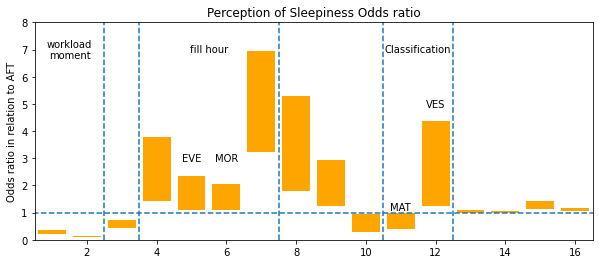

In [15]:
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))

odds_var = np.exp(mdf.conf_int())[1:17]
#x = odds_var.index
x = np.linspace(1,len(odds_var),len(odds_var))
y_bottom = np.array(odds_var[0])
y_diff = np.array(odds_var[1]) - np.array(odds_var[0])
ax.bar(x, y_diff, bottom=y_bottom, color = 'orange')
ax.vlines(x = 2.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 3.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 7.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 10.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 12.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.hlines(xmin = 0, xmax = 20, y = 1, linestyles='dashed')
ax.text(1.5,7,'workload\nmoment', horizontalalignment='center',verticalalignment='center')
ax.text(5.5,7,'fill hour', horizontalalignment='center',verticalalignment='center')
ax.text(11.5,7,'Classification', horizontalalignment='center',verticalalignment='center')
ax.text(5,3,'EVE', horizontalalignment='center',verticalalignment='center')
ax.text(6,3,'MOR', horizontalalignment='center',verticalalignment='center')
ax.text(11,1.2,'MAT', horizontalalignment='center',verticalalignment='center')
ax.text(12,5,'VES', horizontalalignment='center',verticalalignment='center')
ax.set_ylim([0,8])
ax.set_xlim([0.5, 16.5])
ax.set_ylabel('Odds ratio in relation to AFT')
ax.set_title('Perception of Sleepiness Odds ratio')

Figure above presents the 95% odds ratio interval for all covariates.

* For fill hour covariate, we can see a lot of overlapping between categories EVE and MOR, indicating that these two categories can be merged into a single category. However, it is a random slope and random intercept, so we opt to keep this variable as it is.

* For Classification, the MAT category has the 95% confidence bound ranging from positive to negative values, indicating that MAT (Matutin) category does not differ in terms of odds ratio of the baseline category, i.e. INT (Intermediary), so MAT and INT categories can be merged into a single category, MAT_INT.

So, follows the third iteration.

## 4.4. Fourth Iteration

In [16]:
covariates = ['workload_moment','workload_type','quest_fill_hour','workload_length',
              'time_awake','time_displacement','flight_hours','Position',
              'marital_status','education','Classification']

formula = get_formula(covariates, 'kss')

working_df3 = working_df2.copy()
working_df3['Classification'] = working_df3['Classification'].copy().apply(lambda x: 'MAT_INT' if x in ['MAT','INT'] else x)

md3 = smf.mixedlm(formula,working_df3, groups=working_df3["Id"], re_formula = 'quest_fill_hour')
# equivalent coded in r as y~x1+x2+..+xn+(1+xn|Id)

mdf3 = md3.fit()
print(mdf3.summary())

                             Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              kss       
No. Observations:              1014                 Method:                          REML      
No. Groups:                    43                   Scale:                           2.2155    
Min. group size:               8                    Log-Likelihood:                  -1919.1266
Max. group size:               39                   Converged:                       Yes       
Mean group size:               23.6                                                            
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                            3.379    0.533  

The wald test, presents that the variables:

* Education presents high p-value (0.056)
* workload_length presents high pvaue (0.153)

So in the next iteration these variable will be taken, considering a significance level of 0.05.

## 4.5. Fifth Iteration - Parsimonious Model

In [17]:
covariates = ['workload_moment','workload_type','quest_fill_hour',
              'time_awake','time_displacement','flight_hours','Position',
              'marital_status','Classification']

formula = get_formula(covariates, 'kss')

working_df4 = working_df3.copy()

md4 = smf.mixedlm(formula, working_df4, groups=working_df3["Id"], re_formula = 'quest_fill_hour')
# equivalent coded in r as y~x1+x2+..+xn+(1+xn|Id)

mdf4 = md4.fit()
print(mdf4.summary())

                             Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              kss       
No. Observations:              1014                 Method:                          REML      
No. Groups:                    43                   Scale:                           2.2200    
Min. group size:               8                    Log-Likelihood:                  -1918.8547
Max. group size:               39                   Converged:                       Yes       
Mean group size:               23.6                                                            
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                            3.074    0.438  

Above it is shown the output of the chosen model!

### 4.5.1. Coefficients Interpretation

Logistic model coefficients can be interpreted as odds ratio. Due to the link function, odds ratio is obtained through exponentiation of the coefficient, so:

<p style="text-align: center;"> odds ratio = exp(coefficient) </p><br>


we will apply this rationale to all fixed effects and random slope parameters.

Text(0.5, 1.0, 'Perception of Sleepiness Odds ratio - Parsimonious Model')

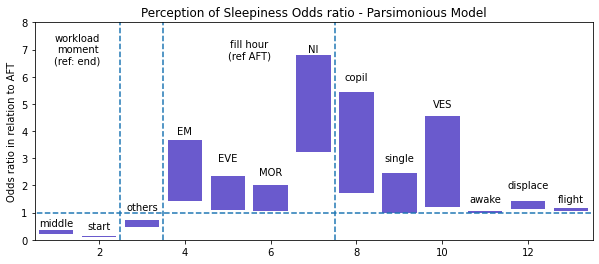

In [18]:
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))

odds_var = np.exp(mdf4.conf_int())[1:14]
#x = odds_var.index
x = np.linspace(1,len(odds_var),len(odds_var))
y_bottom = np.array(odds_var[0])
y_diff = np.array(odds_var[1]) - np.array(odds_var[0])
ax.bar(x, y_diff, bottom=y_bottom, color = 'slateblue')
ax.vlines(x = 2.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 3.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 7.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.hlines(xmin = 0, xmax = 20, y = 1, linestyles='dashed')
ax.text(1.5,7,'workload\nmoment\n(ref: end)', horizontalalignment='center',verticalalignment='center')
ax.text(5.5,7,'fill hour\n(ref AFT)', horizontalalignment='center',verticalalignment='center')
ax.text(1,.6,'middle', horizontalalignment='center',verticalalignment='center')
ax.text(2,.5,'start', horizontalalignment='center',verticalalignment='center')
ax.text(3,1.2,'others', horizontalalignment='center',verticalalignment='center')
ax.text(4,4,'EM', horizontalalignment='center',verticalalignment='center')
ax.text(5,3,'EVE', horizontalalignment='center',verticalalignment='center')
ax.text(6,2.5,'MOR', horizontalalignment='center',verticalalignment='center')
ax.text(7,7,'NI', horizontalalignment='center',verticalalignment='center')
ax.text(8,6,'copil', horizontalalignment='center',verticalalignment='center')
ax.text(9,3,'single', horizontalalignment='center',verticalalignment='center')
ax.text(10,5,'VES', horizontalalignment='center',verticalalignment='center')
ax.text(11,1.5,'awake', horizontalalignment='center',verticalalignment='center')
ax.text(12,2,'displace', horizontalalignment='center',verticalalignment='center')
ax.text(13,1.5,'flight', horizontalalignment='center',verticalalignment='center')
ax.set_ylim([0,8])
ax.set_xlim([0.5, 13.5])
ax.set_ylabel('Odds ratio in relation to AFT')
ax.set_title('Perception of Sleepiness Odds ratio - Parsimonious Model')

Figure above presents the 95% confidence bounds of the coefficients as odds ratio.

In [19]:
# getting odds ratio and confidence bounds
odds = pd.DataFrame( {'odds':np.exp(mdf4.params)[1:14], 'lower':odds_var[0], 'upper':odds_var[1] } )

Categorical variables such as Workload Moment and Hour wherein the kss and sps were filled are composed by more than one category, and the odds ratio are presented in relation to a give reference level, to address this issue it is possible to obtain a matrix with all the possible combination of reference levels.

Bellow the coefficients of Workload Moment and Hour wherein kss and sps scales were filled is presented for all possible reference levels.

In [21]:
def get_odds_matrix(temp, upper, lower, cats):
    x = [[f'{temp[j]/temp[i]:2.2f} [{min( upper[j]/upper[i],lower[j]/lower[i]):2.2f}, {max( upper[j]/upper[i],lower[j]/lower[i]):2.2f}]' for j in range(len(temp))] for i in range(len(temp))]
    return pd.DataFrame(x, columns = cats, index = cats)

temp =  [odds.odds[0:2][1],odds.odds[0:2][0], 1]
upper = [odds.upper[0:2][1],odds.upper[0:2][0], 1]
lower = [odds.lower[0:2][1],odds.lower[0:2][0], 1]
cats = ['start','middle','end'];
moment = get_odds_matrix(temp, upper,lower, cats)

temp = [odds.odds[3:7][0], odds.odds[3:7][2], 1, odds.odds[3:7][1], odds.odds[3:7][3]]
upper = [odds.upper[3:7][0], odds.upper[3:7][2], 1, odds.upper[3:7][1], odds.upper[3:7][3]]
lower = [odds.lower[3:7][0], odds.lower[3:7][2], 1, odds.lower[3:7][1], odds.lower[3:7][3]]
cats = ['EM','MOR','AFT','EVE','NI']
fill = get_odds_matrix(temp, upper, lower, cats)

print(''); print('')
display_side_by_side([moment, fill],['(a) Workload Moment','(b) time the participant filled kss and sps scales'])
print(''); print('')

Above, the coefficients in terms of odds ratio for workload moment and hour where kss scale were filled is presented, rows represent the reference level and columns represent the category to be compared.

**For workload moment we have:**

* The odds of **excessive sleepiness** at the **middle** of workload are 147% (OR=2.47 [2.47,2.47]) **higher than** at the **start** of workload keeping all the other covariates constant
* The odds of **excessive sleepiness** at the **end** of workload are 737% (OR=8.37 [6.55,10.68]) **higher than** at the **start** of workload keeping all the other covariates constant
* The odds of **excessive sleepiness** at the **end** of workload are 239% (OR=3.39 [2.66,4.32]) **higher than** at the **middle** of workload keeping all the other covariates constant

**For time the participant filled the kss and sps scales we have:**

* The odds of **excessive sleepiness** at the **Early Monrning** are 130% (OR=2.30 [1.43,3.67]) **higher than** at the **Afternoon** keeping all the other covariates constant;
* The odds of **excessive sleepiness** at the **Monrning** are 48% (OR=1.48 [1.07,2.03]) **higher than** at the **Afternoon** keeping all the other covariates constant;
* The odds of **excessive sleepiness** at the **Evening** are 62% (OR=1.48 [1.11,2.25]) **higher than** at the **Afternoon** keeping all the other covariates constant;
* The odds of **excessive sleepiness** at the **Night** are 368% (OR=4.68 [3.22,6.82]) **higher than** at the **Afternoon** keeping all the other covariates constant;

In [55]:
temp = pd.DataFrame( {'odds':odds.odds[[2,7,8,9,10,11,12]], 'lower':odds.lower[[2,7,8,9,10,11,12]], 'upper':odds.upper[[2,7,8,9,10,11,12]] })
temp.odds[0], temp.lower[0], temp.upper[0] = 1/temp.odds[0] , 1/temp.lower[0], 1/temp.upper[0]
temp = temp.rename(index = {'workload_type[T.others]':'workload_type[T.night]'})

print(''); print('')
display_side_by_side([temp[0:4], temp[4:]],['(a) Dicotomous ','(b) Continuous'])
print(''); print('')

,odds,lower,upper
workload_type[T.night],1.76,2.21,1.40
Position[T.COPIL],3.06,1.71,5.45
marital_status[T.single],1.57,1.00,2.47
Classification[T.VES],2.34,1.21,4.54
,odds,lower,upper
time_awake,1.04,1.00,1.07
time_displacement,1.27,1.12,1.44
flight_hours,1.10,1.05,1.16


**For dicotomous variables we have:**

* The odds of **excessive sleepiness** for **workloads comprehending Night period** are 76% (OR=1.76 [1.40, 2.21]) **higher** than **other workload modalities** keeping all other covariates constant.
* The odds of **excessive sleepiness** for **Co-Pilots** are 206% (OR=3.06 [1.71, 5.45]) **higher** than **commanders** keeping all other covariates constant.
* The odds of **excessive sleepiness** for **chronotypes vespertines** are 134% (OR=2.34 [1.21, 4.54]) **higher** than for **chronotypes matutines or intermediaries** keeping all other covariates constant.
* The odds of **excessive sleepiness** for participants **singles** are 57% (OR=1.57 [1.00, 2.47]) **higher** than for participants **married** keeping all other covariates constant.

**For continuous variables we have:**

* For **each hour** of **time awake before the workload**, the odds of **excessive sleepiness** raises by 4% (OR=1.04 [1.00, 1.07]).
* For **each hour** of **travel time home to work**, the odds of **excessive sleepiness** raises by 27% (OR=1.27 [1.12, 1.44]).
* For **each thousand hours** of **flight hours experience**, the odds of **excessive sleepiness** raises by 10% (OR=1.10 [1.05, 1.16]).

 

### 4.5.2. Miscellaneous

#### Variability intra clusters

Variability between random effects, i.e. participants and time the participant filled kss, can be assessed through a Median Odds Ratio (MOR). Following Hosmer and Lemeshow seminal book entitled "Applied Logistical Regression", we MOR is given by:

<p style="text-align: center;"> $\hat{MOR} = exp(z_{0.75}\sqrt[]{2 \hat{\sigma}^{2}})$ </p><br>

so, for random intercepts we have:

(Obs: For the time the individuals filled kss scale, does not make practical sense to compute MOR not conditioned to participant, once the time random covariate is clutered inside participant cluster, so we used covariance between participant and its corresponding time rather than the time variance.)

In [76]:
index = ['Participant', 'EM', 'MOR', 'EVE', 'NI']
# It does not make practical sense to access variability in individual time when participant filled kss!
#sigma_squared = np.array([0.33, 0.714, 0.193, 0.552, 0.503]) 
sigma_squared = np.array([0.33, -0.11, 0.115, 0.034, -0.161])
mor = np.exp(0.6745*np.sqrt(2*np.exp(sigma_squared)))
pd.DataFrame({'':index, 'mor':mor}).set_index('').transpose().round(2)

,Participant,EM,MOR,EVE,NI
mor,3.08,2.47,2.75,2.64,2.41


Above the median odds ratio (MOR) is presented for all random intercepts. As we can see the greater variability is the cluster formed by EM, followed by EVE and so on.

The interpretation of this quantity is the following:

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 208% (MOR = 3.08) higher than for the less prone in all such pairs;

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 147% (MOR = 2.47) higher than for the less prone in all such pairs, conditioned to Early-Morning in relation to the Afternoon period.

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 175% (MOR = 2.75) higher than for the less prone in all such pairs, conditioned to Morning in relation to the Afternoon period.

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 164% (MOR = 2.64) higher than for the less prone in all such pairs, conditioned to Evening in relation to the Afternoon period.

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 141% (MOR = 2.41) higher than for the less prone in all such pairs, conditioned to Night in relation to the Afternoon period.

#### How the measurements were correlated along the time the participants filled kss?

In [78]:
mdf4.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
===============================================================================================
Model:                         MixedLM              Dependent Variable:              kss       
No. Observations:              1014                 Method:                          REML      
No. Groups:                    43                   Scale:                           2.2200    
Min. group size:               8                    Log-Likelihood:                  -1918.8547
Max. group size:               39                   Converged:                       Yes       
Mean group size:               23.6                                                            
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                            3.074    0.438   7.014 0.000  2.215  3.932
workload_moment[T.middle]                           -1.220    0.124  -9.832 0.000 -1.464 -0.977
workload_moment[T.start]                            -2.124    0.125 -17.050 0.000 -2.368 -1.880
workload_type[T.others]                             -0.563    0.117  -4.813 0.000 -0.792 -0.334
quest_fill_hour[T.EM]                                0.831    0.240   3.465 0.001  0.361  1.301
quest_fill_hour[T.EVE]                               0.482    0.191   2.526 0.012  0.108  0.856
quest_fill_hour[T.MOR]                               0.389    0.162   2.402 0.016  0.072  0.706
quest_fill_hour[T.NI]                                1.544    0.191   8.065 0.000  1.169  1.919
Position[T.COPIL]                                    1.117    0.296   3.780 0.000  0.538  1.696
marital_status[T.single]                             0.451    0.230   1.962 0.050  0.001  0.902
Classification[T.VES]                                0.852    0.337   2.526 0.012  0.191  1.512
time_awake                                           0.038    0.017   2.187 0.029  0.004  0.071
time_displacement                                    0.237    0.064   3.704 0.000  0.111  0.362
flight_hours                                         0.096    0.026   3.687 0.000  0.045  0.148
Group Var                                            0.333    0.122                            
Group x quest_fill_hour[T.EM] Cov                   -0.111    0.155                            
quest_fill_hour[T.EM] Var                            0.714    0.368                            
Group x quest_fill_hour[T.EVE] Cov                   0.034    0.117                            
quest_fill_hour[T.EM] x quest_fill_hour[T.EVE] Cov  -0.093    0.192                            
quest_fill_hour[T.EVE] Var                           0.552    0.218                            
Group x quest_fill_hour[T.MOR] Cov                   0.115    0.119                            
quest_fill_hour[T.EM] x quest_fill_hour[T.MOR] Cov   0.248    0.233                            
quest_fill_hour[T.EVE] x quest_fill_hour[T.MOR] Cov -0.155    0.142                            
quest_fill_hour[T.MOR] Var                           0.193    0.211                            
Group x quest_fill_hour[T.NI] Cov                   -0.161    0.138                            
quest_fill_hour[T.EM] x quest_fill_hour[T.NI] Cov    0.224    0.209                            
quest_fill_hour[T.EVE] x quest_fill_hour[T.NI] Cov   0.415    0.186                            
quest_fill_hour[T.MOR] x quest_fill_hour[T.NI] Cov  -0.094    0.161                            
quest_fill_hour[T.NI] Var                            0.503    0.221                            
===============================================================================================

"""